In [2]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import seaborn as sns
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)

from scipy.special import gamma as fgamma
def gamma(x, a, b):
    '''pdf of gamma(shape, rate)'''
    return b ** a / fgamma(a) * x ** (a - 1) * np.exp(-b * x)



In [3]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 3.45 s, sys: 223 ms, total: 3.68 s
Wall time: 4.1 s


In [4]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [5]:
df_corr_DMS = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr_NaC = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'NaC'])


In [6]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS

for df_i in [df_corr_DMS, df_corr_NaC]:

    df_i['bQ_dir_diff'] = pd.cut(df_i['Q_dir_diff'], Q_BINS)
    df_i['bQ_ch_diff'] = pd.cut(df_i['Q_ch_diff'], Q_BINS)

    # quantile cuts for raw Q values 
    df_i['bQ_chosen'] = pd.qcut(df_i['Q_chosen'], Q_BINS_QUANTILES)
    df_i['bQ_c'] = pd.qcut(df_i['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


# Figure 1

Done


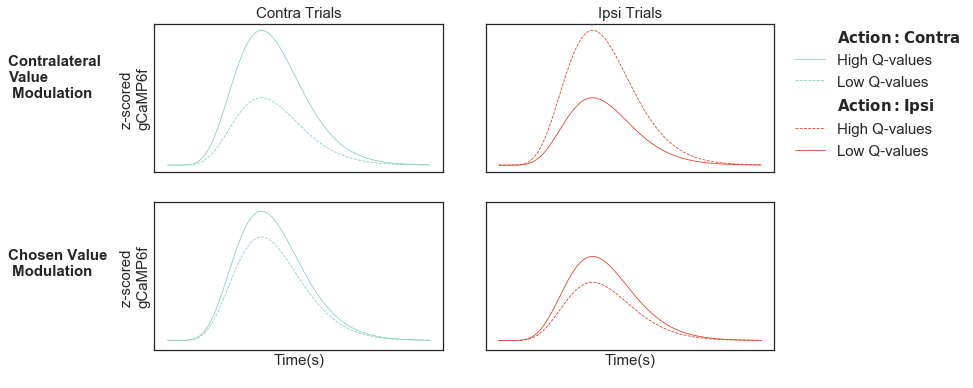

In [15]:
sz = 15

def set_figure(ax):
    ax.set_yticks([])
    ax.set_xticks([])

# basic plot 

meanlag = 6
stddev = 2

a = (meanlag/stddev) ** 2
b = meanlag/(stddev ** 2)

x = np.arange(0, 15, 0.1)
y = gamma(np.arange(0, 15, 0.1), a, b)

# colors 

c_col = sns.color_palette(sns.color_palette('GnBu', 20))[9]
i_col = sns.color_palette(sns.color_palette('YlOrRd_d', 10))[4]

# palettes 

figure = plt.figure(figsize=(10,6))
subfigs = np.array([['a', 'b','c'],[ 'd','e', 'f']])
gs = gridspec.GridSpec(2, 3, width_ratios = [0.2, 1, 1])

ax = plt.subplot(gs[0, 0])

ax.text(-0.8, 0.5, 'Contralateral \nValue\n Modulation', weight = 'bold', size = sz)
ax.axis('off')

ax = plt.subplot(gs[1, 0])

ax.text(-0.8, 0.5, 'Chosen Value \n Modulation', weight = 'bold', size = sz)
ax.axis('off')

# contra theory 
ax = plt.subplot(gs[0, 1])
# ax.plot(x, y * 0.9, linewidth = 2, color = 'dimgrey')

ax.plot(x, y, linewidth = 0.8, color  = c_col)
ax.plot(x, y * 0.5, linewidth = 0.8, linestyle = '--', color  = c_col)
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_title('Contra Trials', size = sz)

ax = plt.subplot(gs[0, 2])

# l1, = ax.plot(x, y * 0.6, linewidth = 2, color = 'dimgrey', label = 'Average')

l2 = ax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = ax.plot([], color = c_col, label = 'High Q-values', lw = 0.8)
l4, = ax.plot([], color = c_col, linestyle = '--', label = 'Low Q-values', lw = 0.8)

l5 = ax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = ax.plot(x, y, linewidth = 0.8, label = 'High Q-values', color = i_col, ls = '--')
l7, = ax.plot(x, y * 0.5, linewidth = 0.8, label = 'Low Q-values ', color  = i_col)

set_figure(ax)
ax.set_title('Ipsi Trials', size = sz)

lgd = plt.legend(handles = [l2, l3, l4, l5, l6, l7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = sz)
# ax = plt.subplot(gs[0, 2])
ax = plt.subplot(gs[1, 1])
# ax.plot(x, y * 1.8, linewidth = 2, color = 'dimgrey')

ax.plot(x, y * 1.6, linewidth = 0.8, color  = c_col, linestyle = '--')
ax.plot(x, y * 2, linewidth = 0.8, color  = c_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)

ax.set_xlabel('Time(s)', size = sz)

ax = plt.subplot(gs[1, 2])
# ax.plot(x, y * 1.1, linewidth = 2, color = 'dimgrey')

ax.plot(x, y *1.3, linewidth = 0.8, color = i_col)
ax.plot(x, y * 0.9, linewidth = 0.8, linestyle = '--', color = i_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)

ax.set_xlabel('Time(s)', size = sz)
plt.subplots_adjust(left = -0.1)
plt.savefig('figs/Fig1', dpi=180, bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.close()

print('Done')


# ax = plt.subplot(gs[1, 4])
# ax.set_xlabel('Time(s)', size = sz)

# ax.plot(x, y *1, linewidth = 0.8, color = i_col)
# ax.plot(x, y * 0.6, linewidth = 0.8, color = i_col, ls = '--')
# ax.plot(x, y * 1.6, linewidth = 0.8, color = c_col, ls = '--')
# ax.plot(x, y * 2, linewidth = 0.8, color = c_col)
# set_figure(ax)

# ax = plt.subplot(gs[0, 4])


# ax.plot(x, y *1, linewidth = 0.8, color = i_col, ls = '--')
# ax.plot(x, y * 0.6, linewidth = 0.8, color = i_col, ls = '-')
# ax.plot(x, y * 1.6, linewidth = 0.8, color = c_col, ls = '--')
# ax.plot(x, y * 2, linewidth = 0.8, color = c_col, ls = '-')
# set_figure(ax)

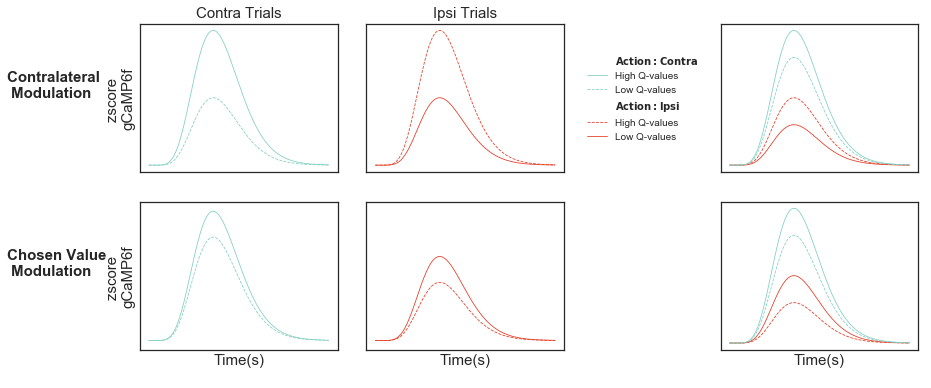

In [12]:
sz = 15

def set_figure(ax):
    ax.set_yticks([])
    ax.set_xticks([])

# basic plot 

meanlag = 6
stddev = 2

a = (meanlag/stddev) ** 2
b = meanlag/(stddev ** 2)

x = np.arange(0, 15, 0.1)
y = gamma(np.arange(0, 15, 0.1), a, b)

# colors 

c_col = sns.color_palette(sns.color_palette('GnBu', 20))[9]
i_col = sns.color_palette(sns.color_palette('YlOrRd_d', 10))[4]



# figures and grids 

figure = plt.figure(figsize=(15,6))
subfigs = np.array([['a', 'b','c'],[ 'd','e', 'f']])
gs = gridspec.GridSpec(2, 5, width_ratios = [0.15, 1, 1, 0.5, 1])


# theories 
ax = plt.subplot(gs[0, 0])

ax.text(-2.5, 0.5, 'Contralateral \n Modulation', weight = 'bold', size = sz)
ax.axis('off')

ax = plt.subplot(gs[1, 0])

ax.text(-2.5, 0.5, 'Chosen Value \n Modulation', weight = 'bold', size = sz)
ax.axis('off')

# contra theory plots
ax = plt.subplot(gs[0, 1])
# ax.plot(x, y * 0.9, linewidth = 2, color = 'dimgrey')

ax.plot(x, y, linewidth = 0.8, color  = c_col)
ax.plot(x, y * 0.5, linewidth = 0.8, linestyle = '--', color  = c_col)
set_figure(ax)
ax.set_ylabel('zscore \ngCaMP6f', size = sz)
ax.set_title('Contra Trials', size = sz)

ax = plt.subplot(gs[0, 2])

# l1, = ax.plot(x, y * 0.6, linewidth = 2, color = 'dimgrey', label = 'Average')

l2 = ax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = ax.plot([], color = c_col, label = 'High Q-values', lw = 0.8)
l4, = ax.plot([], color = c_col, linestyle = '--', label = 'Low Q-values', lw = 0.8)

l5 = ax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = ax.plot(x, y, linewidth = 0.8, label = 'High Q-values', color = i_col, ls = '--')
l7, = ax.plot(x, y * 0.5, linewidth = 0.8, label = 'Low Q-values ',  color  = i_col)

set_figure(ax)
ax.set_title('Ipsi Trials', size = sz)
lax = plt.subplot(gs[0, 3])

plt.legend(handles = [l2, l3, l4, l5, l6, l7], fontsize = 10, loc = 'center')

lax.axis('off')


# chosen theory plots 
ax = plt.subplot(gs[1, 1])
# ax.plot(x, y * 1.8, linewidth = 2, color = 'dimgrey')

ax.plot(x, y * 1.6, linewidth = 0.8, color  = c_col, linestyle = '--')
ax.plot(x, y * 2, linewidth = 0.8, color  = c_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)
ax.set_ylabel('zscore \ngCaMP6f', size =sz)

ax.set_xlabel('Time(s)', size = sz)

ax = plt.subplot(gs[1, 2])
# ax.plot(x, y * 1.1, linewidth = 2, color = 'dimgrey')

ax.plot(x, y *1.3, linewidth = 0.8, color = i_col)
ax.plot(x, y * 0.9, linewidth = 0.8, linestyle = '--', color = i_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)

ax.set_xlabel('Time(s)', size = sz)



# plt.tight_layout()


# Figure 2

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


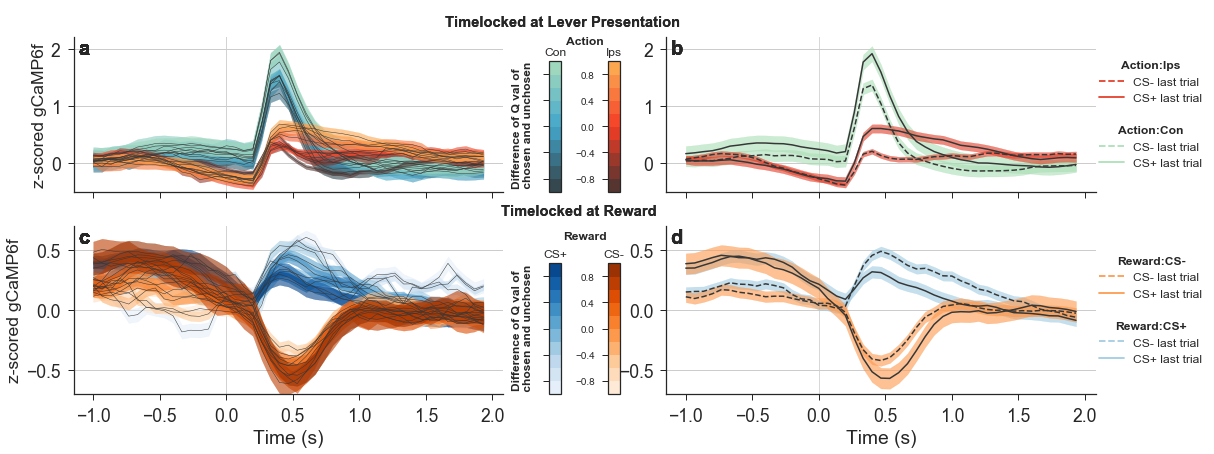

In [11]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q val of \n chosen and unchosen'
ylims = [[-0.5, 2.2], [-0.7, 0.7]]
figure = plt.figure(figsize=(20, 7))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(6, 5,
                       width_ratios=[9, 0.25, 0.25, 9, 1], height_ratios = [0.1, 0.1, 1, 0.1, 0.2, 1])


gs.update(wspace=0.25)

qlims = np.unique(df_corr_DMS['b' + Q_to_plot].dropna())
_palettes =  [['GnBu_d', 'YlOrRd_d'], [ 'Blues', 'Oranges']]
line_styles = ['--', '-']

for j, [src, lines] in enumerate(zip(['qval', 'gcamp'], [qlims, np.arange(2)])):
    

    for i, [timelocked, tl_name] in enumerate(zip(['g_lp',  'g_reward'], 
                                                           ['Lever Presentation',  'Reward'])):
        palettes = _palettes[i]

        
        if tl_name == 'Reward':
            categories = [1, 0]
            column = 'Reward'
            cat_names = ['CS+', 'CS-']
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            cat_names = categories
            
            
        # timelock title
        tl_ax = plt.subplot(gs[i * 3, :])
        tl_ax.axis('off')
#         tl_ax.set_title(tl_name)
        tl_ax.text(0.333 + i * 0.05, 0, 'Timelocked at ' + tl_name, size = 'x-small', weight = 'bold')
                                        
        # legend plotting 1. colorbar for the q values 
        if j == 0:
            with sns.axes_style("white"):

                lax_title = plt.subplot(gs[i * 3 +1, j + 1 : (j + 3)])
                lax_title.text(0.5, 0.5, column, size = 'xx-small', weight = 'bold', ha = 'center')

                lax_title.axis('off')
                
        
        lax2 = plt.subplot(gs[(i * 3 + 1): (i * 3 + 3), -1])

        for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
            if palette == 'GnBu_d' and src == 'gcamp':
                palette = 'GnBu'
            color_palette = sns.color_palette(palette, len(qlims))
  
            cmap = ListedColormap(color_palette.as_hex())
            bounds = [x.left for x in qlims] + [qlims[-1].right]
            norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
            if j == 0:

                lax = plt.subplot(gs[i * 3 + 2, j + 1 + p_i])
                dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                lax.cla()
                cbar = plt.colorbar(dummy_plot, cax = lax)

                
                cbar.ax.set_title(subcat, size = 'xx-small')


                if p_i == 0:
                    cbar.ax.set_yticklabels([])
                    cbar.set_label(Q_to_plot_name, size =  12, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
                if p_i == 1:
                    cbar.ax.tick_params(labelsize = 10)
#                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
            if j == 1:
                
                ln1, = lax2.plot([], color = color_palette[3 + p_i], linestyle = line_styles[0], label = 'CS- last trial')
                ln2, = lax2.plot([], color = color_palette[3 + p_i], linestyle = line_styles[1], label = 'CS+ last trial')
                
                lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
                                 fontsize = 'xx-small', loc= (p_i * 3 + 1), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
                plt.setp(lgd.get_title(),fontsize='xx-small', weight = 'bold')

                if p_i == 0:
                    lax2.add_artist(lgd)

                lax2.axis('off')


        ax = plt.subplot(gs[i*3 + 1: (i * 3 + 3), j*3])


        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
            if palette == 'GnBu_d' and src == 'gcamp':
                palette = 'GnBu'
            color_palette = sns.color_palette(palette, len(qlims))


            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5
                elif src == 'gcamp':
                    gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[3 + subcat_i]
                    lw = 1.5
                    ls_i = line_styles[l_i]

                error = np.std(y, axis = 0) / np.sqrt(NS)
                ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
                ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
#                 # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
                plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0:
                    plt.ylabel('z-scored gCaMP6f', size = 'small')

                # x axis 
                if i == 1:
                    plt.xlabel('Time (s)')
                else:
                    plt.xlabel('')
                    ax.xaxis.set_ticklabels([])
                
                # grid lines
                ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

# plt.savefig('figs/Fig2', dpi=200)
# print('Done')

# Figure 3

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


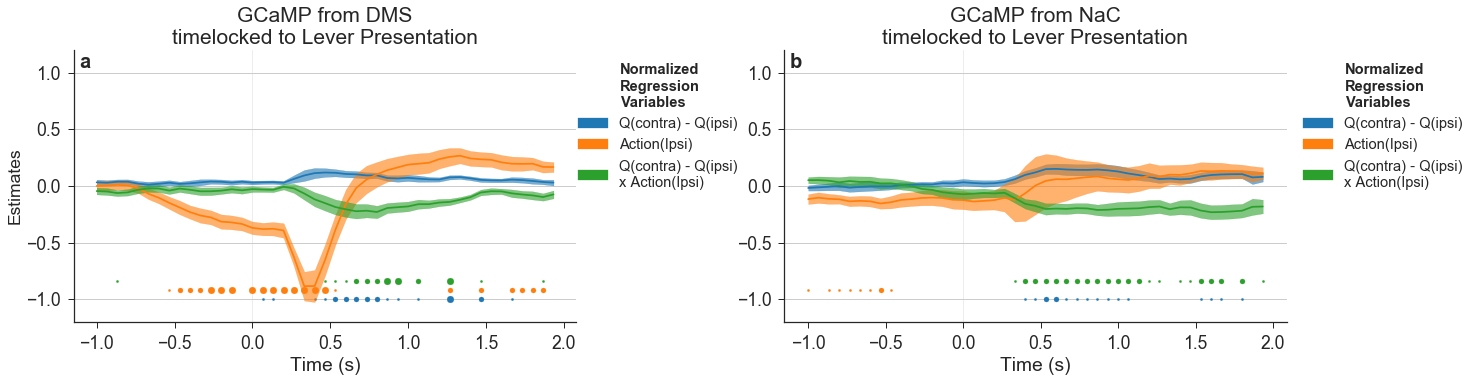

In [16]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')

ylim = [-1.2, 1.2]
figure = plt.figure(figsize=(24, 5))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
sig = [0.05, 0.01, 0.001]
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[9, 1.2, 9, 1])

gs.update(wspace=0.25)

pval_gap = 0.08 
lines = np.arange(2)

for j, recordloc in enumerate(['DMS', 'NaC']):

    

    for i, [timelocked, tl_name] in enumerate(zip(['dir_lever_m'], 
                                                           ['Lever Presentation'])):


        ax = plt.subplot(gs[i, j*2])
        lax = plt.subplot(gs[i, j*2 + 1])

        df_src = pd.read_csv('data/' + recordloc + '/' + timelocked + '.csv')
        df_src = df_src[df_src['names']!= '(Intercept)']
        
        
        num_var = len(np.unique(df_src['names']))
        sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
        for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], sns.color_palette('tab10', num_var ))):
            df_i = df_src[df_src['names'] == n]
            ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
            if ((i == 3) and (j == 1)):
                pval_gap = 0.12
            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
                y = np.ones(len(x)) * -1 + ln_i * pval_gap

                ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
            if n == 'Q_dir_diff:ActionIps':
                n = 'Q(contra) - Q(ipsi) \nx Action(Ipsi)'
            if n == 'Q_dir_diff':
                n = 'Q(contra) - Q(ipsi)'
            if n == 'ActionIps':
                n = 'Action(Ipsi)'
            lax.fill_between([], [], [], color = col, label = n)


        if j == 0:
            l = 'upper center'
            lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                             fontsize = 'x-small', loc = l, bbox_to_anchor=(0.2, 1.0))
            
            
        else:
            l = 'upper center'
            lgd = lax.legend(title = 'Normalized\nRegression\nVariables', fontsize = 'x-small', loc = l)

        plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
        lax.axis('off')


        # title
        if i == 0:
            ax.set_title('GCaMP from ' + recordloc + '\ntimelocked to ' + tl_name)

        # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        ax.set_ylim(ylim)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
        if j == 0:
            ax.set_ylabel('Estimates', size = 'small')
        else:
            ax.set_ylabel('')
            # x axis 

        ax.set_xlabel('Time (s)')

                
        # grid lines
        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




plt.tight_layout()
sns.despine()

# plt.savefig('figs/Fig4_v1', dpi=180)
# # plt.close()
# print('Done')


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


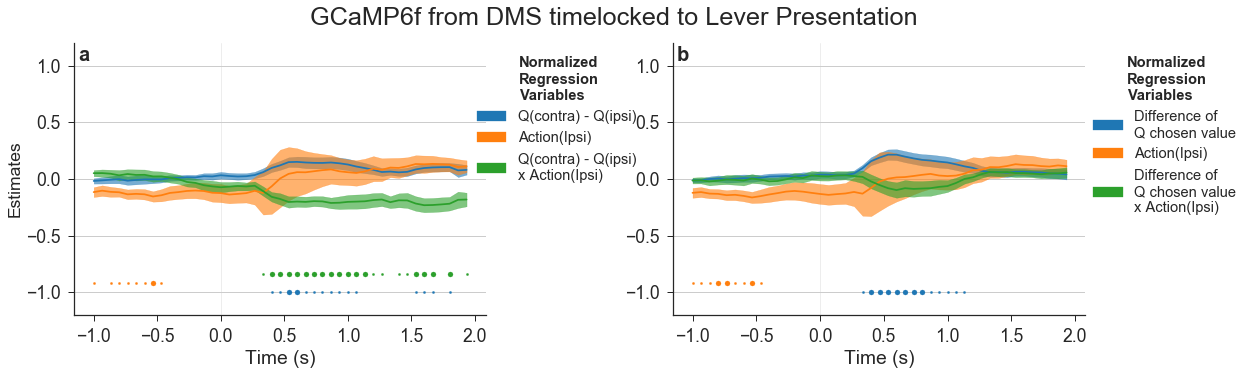

In [18]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')

ylim = [-1.2, 1.2]
figure = plt.figure(figsize=(20, 5))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
sig = [0.05, 0.01, 0.001]
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[9, 1.5, 9, 1])

gs.update(wspace=0.25)

pval_gap = 0.08 
lines = np.arange(2)
i = 0 
plt.suptitle('GCaMP6f from DMS timelocked to Lever Presentation')

for j, [timelocked, tl_name] in enumerate(zip(['dir_lever_m', '_lever_m'], 
                                                           ['Lever Presentation', 'Lever Presentation'])):


        ax = plt.subplot(gs[i, j*2])
        lax = plt.subplot(gs[i, j*2 + 1])

        df_src = pd.read_csv('data/' + recordloc + '/' + timelocked + '.csv')
        df_src = df_src[df_src['names']!= '(Intercept)']
        
        
        num_var = len(np.unique(df_src['names']))
        sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
        for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], sns.color_palette('tab10', num_var ))):
            df_i = df_src[df_src['names'] == n]
            ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
            if ((i == 3) and (j == 1)):
                pval_gap = 0.12
            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
                y = np.ones(len(x)) * -1 + ln_i * pval_gap

                ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
            if n == 'Q_dir_diff:ActionIps':
                n = 'Q(contra) - Q(ipsi) \nx Action(Ipsi)'
            if n == 'Q_dir_diff':
                n = 'Q(contra) - Q(ipsi)'
            if n == 'ActionIps':
                n = 'Action(Ipsi)'
            if n == 'Q_ch_diff:ActionIps':
                n = 'Difference of \nQ chosen value \nx Action(Ipsi)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ chosen value'
            lax.fill_between([], [], [], color = col, label = n)


        if j == 0:
            l = 'upper center'
            lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                             fontsize = 'x-small', loc = l, bbox_to_anchor=(0.2, 1.0))
            
            
        else:
            l = 'upper center'
            lgd = lax.legend(title = 'Normalized\nRegression\nVariables', fontsize = 'x-small', loc = l)

        plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
        lax.axis('off')



        # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        ax.set_ylim(ylim)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
        if j == 0:
            ax.set_ylabel('Estimates', size = 'small')
        else:
            ax.set_ylabel('')
            # x axis 

        ax.set_xlabel('Time (s)')

                
        # grid lines
        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




plt.tight_layout()
sns.despine()

# plt.savefig('figs/Fig4', dpi=180)
# # plt.close()
# print('Done')


Done


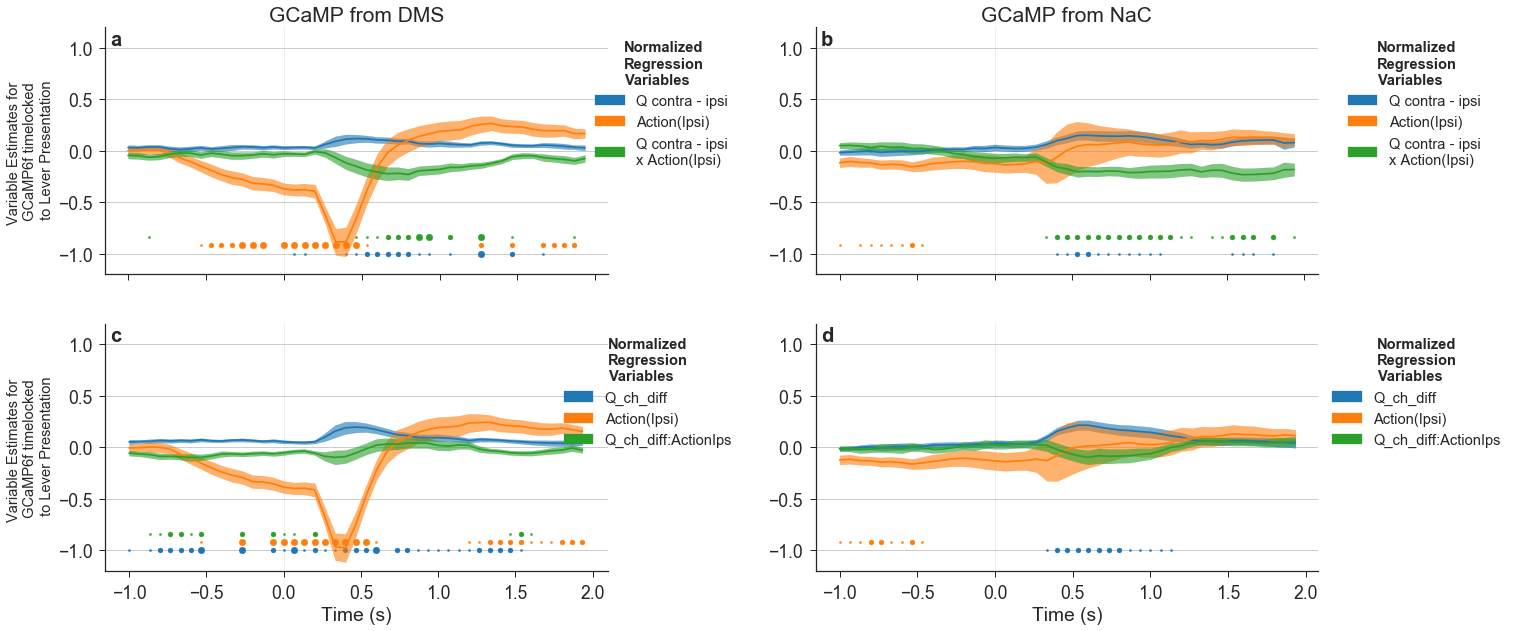

In [19]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')

ylim = [-1.2, 1.2]
figure = plt.figure(figsize=(24, 10))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
sig = [0.05, 0.01, 0.001]
gs = gridspec.GridSpec(2, 4,
                       width_ratios=[9, 1.2, 9, 1])

gs.update(wspace=0.25)

pval_gap = 0.08 
lines = np.arange(2)

for j, recordloc in enumerate(['DMS', 'NaC']):

    

    for i, [timelocked, tl_name] in enumerate(zip(['dir_lever_m', '_lever_m'], 
                                                           ['Lever Presentation', 'Lever Presentation'])):


        ax = plt.subplot(gs[i, j*2])
        lax = plt.subplot(gs[i, j*2 + 1])

        df_src = pd.read_csv('data/' + recordloc + '/' + timelocked + '.csv')
        df_src = df_src[df_src['names']!= '(Intercept)']
        
        
        num_var = len(np.unique(df_src['names']))
        sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
        for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], sns.color_palette('tab10', num_var ))):
            df_i = df_src[df_src['names'] == n]
            ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
            if ((i == 3) and (j == 1)):
                pval_gap = 0.12
            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
                y = np.ones(len(x)) * -1 + ln_i * pval_gap

                ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
            if n == 'Q_dir_diff:ActionIps':
                n = 'Q contra - ipsi \nx Action(Ipsi)'
            if n == 'Q_dir_diff':
                n = 'Q contra - ipsi'
            if n == 'ActionIps':
                n = 'Action(Ipsi)'
            lax.fill_between([], [], [], color = col, label = n)


        if j == 0:
            l = 'best'
        else:
            l = 'upper center'
        lgd = lax.legend(title = 'Normalized\nRegression\nVariables', fontsize = 'x-small', loc = l)
        plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
        lax.axis('off')


        # title
        if i == 0:
            ax.set_title('GCaMP from ' + recordloc)

        # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        ax.set_ylim(ylim)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
        if j == 0:
            ax.set_ylabel('Variable Estimates for \n GCaMP6f timelocked \n to ' + tl_name, size = 'x-small')
        else:
            ax.set_ylabel('')
            # x axis 
        if i == 1:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
                
        # grid lines
        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

# plt.savefig('figs/Fig4', dpi=180)
# plt.close()
print('Done')


# Figure 4


Done


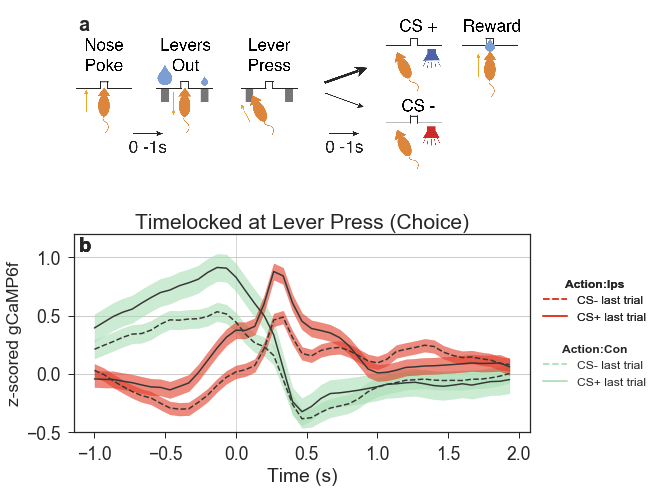

In [173]:


figure = plt.figure(figsize=(10, 8))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[9, 1])

#schematic
ax = plt.subplot(gs[0,0])
im = plt.imread('figs/schematic.jpg')
ax.imshow(im)
ax.axis('off')

ax.annotate('a', (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                

# legends

palettes =  ['GnBu', 'YlOrRd_d']

categories = ['Con', 'Ips']
column = 'Action'
cat_names = categories

timelocked = 'g_choice'
tl_name = 'Lever Press (Choice)'

lax2 = plt.subplot(gs[1, 1])
for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
    color_palette = sns.color_palette(palette, 10)
    ln1, = lax2.plot([], color = color_palette[3 + p_i], linestyle = line_styles[0], label = 'CS- last trial')
    ln2, = lax2.plot([], color = color_palette[3 + p_i], linestyle = line_styles[1], label = 'CS+ last trial')

    lgd = plt.legend(bbox_to_anchor = (1.5,0.5), handles = [ln1, ln2], 
                     fontsize = 'xx-small', loc= (p_i * 3 + 1), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
    plt.setp(lgd.get_title(),fontsize='xx-small', weight = 'bold')

    lax2.add_artist(lgd)
    lax2.axis('off')


ax = plt.subplot(gs[1,0])

ax.set_title('Timelocked at ' + tl_name)
        

for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(sns.color_palette(palette, 10))


    for l_i, col in zip(lines, color_palette):


        gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(gcamp, axis = 0)
        col = color_palette[3 + subcat_i]
        lw = 1.5
        ls_i = line_styles[l_i]

        error = np.std(y, axis = 0) / np.sqrt(NS)
        ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
#                 # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        plt.ylim(-0.5, 1.2)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   

        plt.ylabel('z-scored gCaMP6f', size = 'small')

        plt.xlabel('Time (s)')

        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'


plt.savefig('figs/Fig3', dpi=200)
print('Done')